# Debug Training: Advanced Model from Scratch

This notebook trains the Advanced model from scratch and systematically debugs the prediction issue to ensure proper continuous output.

In [1]:
import os
import sys
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add src to path
sys.path.append('../../src')

from model_runner import ModelRunner

# Set up paths
TRAIN_PATH = "../../data/train_balanced.parquet"
VAL_PATH = "../../data/validation.parquet"
META_PATH = "../../data/meta_model.parquet"
FEATURES_PATH = "../../data/features.json"

print("Setup complete!")

Setup complete!


In [2]:
# Check Advanced model architecture BEFORE training
def load_model(model_name):
    """Load a model by name"""
    module = importlib.import_module(f"models.{model_name}")
    return module.model

def load_optimizer(optimizer_name):
    """Load an optimizer by name"""
    module = importlib.import_module(f"optimizers.{optimizer_name}")
    return module.optimizer

print("Loading Advanced model...")
model = load_model("Advanced")

print("\n=== MODEL ARCHITECTURE BEFORE TRAINING ===")
model.summary()

# Check the final layer specifically
last_layer = model.layers[-1]
print(f"\nLast layer details:")
print(f"- Name: {last_layer.name}")
print(f"- Units: {last_layer.units}")
print(f"- Activation: {last_layer.activation.__name__}")

# Test untrained model with random input
test_input = np.random.random((3, 42)).astype(np.float32)
untrained_preds = model.predict(test_input, verbose=0)
print(f"\nUntrained model predictions (should vary):")
for i, pred in enumerate(untrained_preds):
    print(f"Sample {i+1}: {pred[0]:.6f}")

Loading Advanced model...

=== MODEL ARCHITECTURE BEFORE TRAINING ===
Model: "Advanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               5504      
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                      

In [3]:
# Load optimizer and compile model
print("Loading Adam optimizer...")
optimizer = load_optimizer("Adam")

# Compile for regression
model.compile(
    optimizer=optimizer,
    loss='mae',
    metrics=['mae']
)

print("Model compiled successfully!")

# Initialize ModelRunner
print("\nInitializing ModelRunner...")
runner = ModelRunner(
    path_train=TRAIN_PATH,
    path_val=VAL_PATH,
    path_meta_model=META_PATH,
    path_features=FEATURES_PATH,
    batch_size=64,
    subset_features="small",
    model=model
)

print(f"Training data shape: {runner.train_dataset.shape}")
print(f"Validation data shape: {runner.validation_dataset.shape}")
print(f"Feature count: {len(runner.feature_set['feature_sets'][runner.subset_features])}")

Loading Adam optimizer...
Model compiled successfully!

Initializing ModelRunner...
Training data shape: (678340, 2415)
Validation data shape: (3596488, 2415)
Feature count: 42


=== TRAINING DATA ANALYSIS ===
Features shape: (678340, 42)
Target shape: (678340,)
Feature range: [0.000, 4.000]
Target range: [0.000, 1.000]
Target distribution:
  Mean: 0.500
  Std: 0.354
  Unique values: 5


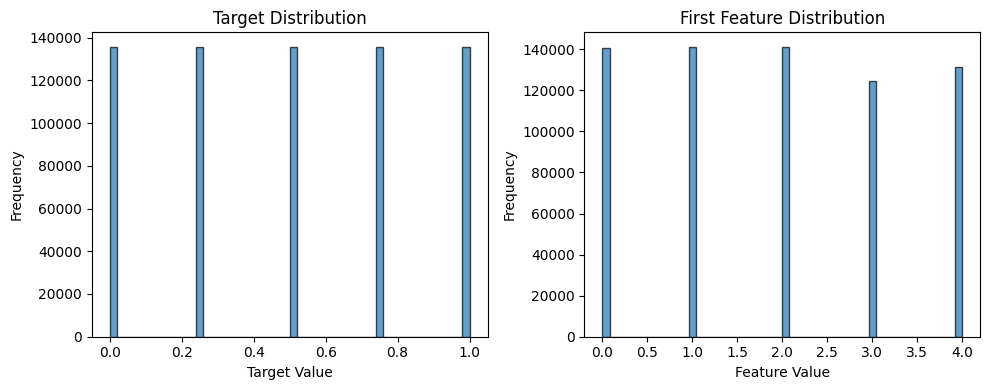


=== UNTRAINED MODEL ON REAL DATA ===
Sample predictions before training:
Target: 0.500, Prediction: 0.534
Target: 0.250, Prediction: 0.309
Target: 0.250, Prediction: 0.306
Target: 1.000, Prediction: 0.359
Target: 0.000, Prediction: 0.500


In [4]:
# Check training data distribution BEFORE training
print("=== TRAINING DATA ANALYSIS ===")

# Get features and target
feature_cols = runner.feature_set["feature_sets"][runner.subset_features]
train_features = runner.train_dataset[feature_cols].values.astype(np.float32)
train_targets = runner.train_dataset["target"].values.astype(np.float32)

print(f"Features shape: {train_features.shape}")
print(f"Target shape: {train_targets.shape}")
print(f"Feature range: [{train_features.min():.3f}, {train_features.max():.3f}]")
print(f"Target range: [{train_targets.min():.3f}, {train_targets.max():.3f}]")
print(f"Target distribution:")
print(f"  Mean: {train_targets.mean():.3f}")
print(f"  Std: {train_targets.std():.3f}")
print(f"  Unique values: {len(np.unique(train_targets))}")

# Plot target distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(train_targets, bins=50, alpha=0.7, edgecolor='black')
plt.title('Target Distribution')
plt.xlabel('Target Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_features[:, 0], bins=50, alpha=0.7, edgecolor='black')
plt.title('First Feature Distribution')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Test untrained predictions on real training data
print("\n=== UNTRAINED MODEL ON REAL DATA ===")
sample_X = train_features[:5]
sample_y = train_targets[:5]
untrained_preds = model.predict(sample_X, verbose=0).squeeze()

print("Sample predictions before training:")
for i in range(5):
    print(f"Target: {sample_y[i]:.3f}, Prediction: {untrained_preds[i]:.3f}")

In [5]:
# Train the model
print("=== STARTING TRAINING ===")
print("Training for 5 epochs to see if model learns...")

model, history = runner.train(epochs=5)

print("\nTraining completed!")
print(f"Training loss: {history.history['loss'][0]:.4f} -> {history.history['loss'][-1]:.4f}")
print(f"Validation loss: {history.history['val_loss'][0]:.4f} -> {history.history['val_loss'][-1]:.4f}")

=== STARTING TRAINING ===
Training for 5 epochs to see if model learns...
Training samples: 610,506
Validation samples: 67,834
Model: "Advanced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               5504      
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                              

In [6]:
# Test predictions AFTER training
print("=== TESTING TRAINED MODEL ===")

# Test on same training samples
trained_preds = model.predict(sample_X, verbose=0).squeeze()

print("\nSame samples after training:")
print("Target vs Untrained vs Trained:")
for i in range(5):
    print(f"{sample_y[i]:.3f} | {untrained_preds[i]:.3f} | {trained_preds[i]:.3f}")

# Test ModelRunner predict method
print("\n=== TESTING MODELRUNNER PREDICT ===")
runner_preds = runner.predict(sample_X)
print("\nModelRunner predictions:")
for i in range(5):
    print(f"Direct: {trained_preds[i]:.3f}, ModelRunner: {runner_preds[i]:.3f}")

# Test with completely new random data
print("\n=== TESTING WITH RANDOM DATA ===")
random_X = np.random.random((5, 42)).astype(np.float32)
random_preds = runner.predict(random_X)
print("Random input predictions:")
for i, pred in enumerate(random_preds):
    print(f"Random {i+1}: {pred:.6f}")

# Check if all predictions are identical
if len(set(np.round(random_preds, 6))) == 1:
    print("\n⚠️  WARNING: All predictions are identical!")
else:
    print(f"\n✅ Good: {len(set(np.round(random_preds, 6)))} different prediction values")

=== TESTING TRAINED MODEL ===

Same samples after training:
Target vs Untrained vs Trained:
0.500 | 0.534 | 0.500
0.250 | 0.309 | 0.500
0.250 | 0.306 | 0.500
1.000 | 0.359 | 0.500
0.000 | 0.500 | 0.500

=== TESTING MODELRUNNER PREDICT ===
1/1 [==============================] - 0s 9ms/step

ModelRunner predictions:
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500

=== TESTING WITH RANDOM DATA ===
1/1 [==============================] - 0s 11ms/step
Random input predictions:
Random 1: 0.500020
Random 2: 0.500020
Random 3: 0.500020
Random 4: 0.500020
Random 5: 0.500019

⚠️  WARNING: All predictions are identical!

ModelRunner predictions:
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500
Direct: 0.500, ModelRunner: 0.500

=== TESTING WITH RANDOM DATA ===
1/1 [===========================

In [7]:
# Test on live data
print("=== TESTING ON LIVE DATA ===")

# Load live data
live_data = pd.read_parquet("../../data/live.parquet")
print(f"Live data shape: {live_data.shape}")

# Get live features
X_live = live_data[feature_cols].values.astype(np.float32)
print(f"Live features shape: {X_live.shape}")
print(f"Live features range: [{X_live.min():.3f}, {X_live.max():.3f}]")

# Generate predictions
print("\nGenerating live predictions...")
live_preds = runner.predict(X_live)

print(f"\nLive prediction results:")
print(f"Shape: {live_preds.shape}")
print(f"Range: [{live_preds.min():.6f}, {live_preds.max():.6f}]")
print(f"Mean: {live_preds.mean():.6f}")
print(f"Std: {live_preds.std():.6f}")
print(f"Unique values (rounded to 6 decimals): {len(set(np.round(live_preds, 6)))}")

# Show first 10 predictions
print(f"\nFirst 10 predictions:")
for i in range(10):
    print(f"  {i+1}: {live_preds[i]:.6f}")

# Check if all predictions are the same
if live_preds.std() < 1e-6:
    print("\n❌ PROBLEM: All live predictions are essentially the same!")
    print("This indicates the model is not working properly.")
else:
    print(f"\n✅ SUCCESS: Predictions show variation (std = {live_preds.std():.6f})")

=== TESTING ON LIVE DATA ===
Live data shape: (6382, 2415)
Live features shape: (6382, 42)
Live features range: [0.000, 4.000]

Generating live predictions...
200/200 [==============================] - 0s 446us/step

Live prediction results:
Shape: (6382,)
Range: [0.499967, 0.508512]
Mean: 0.500024
Std: 0.000132
Unique values (rounded to 6 decimals): 43

First 10 predictions:
  1: 0.500022
  2: 0.500022
  3: 0.500022
  4: 0.500022
  5: 0.500012
  6: 0.500022
  7: 0.500022
  8: 0.500022
  9: 0.500022
  10: 0.500020

✅ SUCCESS: Predictions show variation (std = 0.000132)

Live prediction results:
Shape: (6382,)
Range: [0.499967, 0.508512]
Mean: 0.500024
Std: 0.000132
Unique values (rounded to 6 decimals): 43

First 10 predictions:
  1: 0.500022
  2: 0.500022
  3: 0.500022
  4: 0.500022
  5: 0.500012
  6: 0.500022
  7: 0.500022
  8: 0.500022
  9: 0.500022
  10: 0.500020

✅ SUCCESS: Predictions show variation (std = 0.000132)


=== VISUALIZATION ===


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

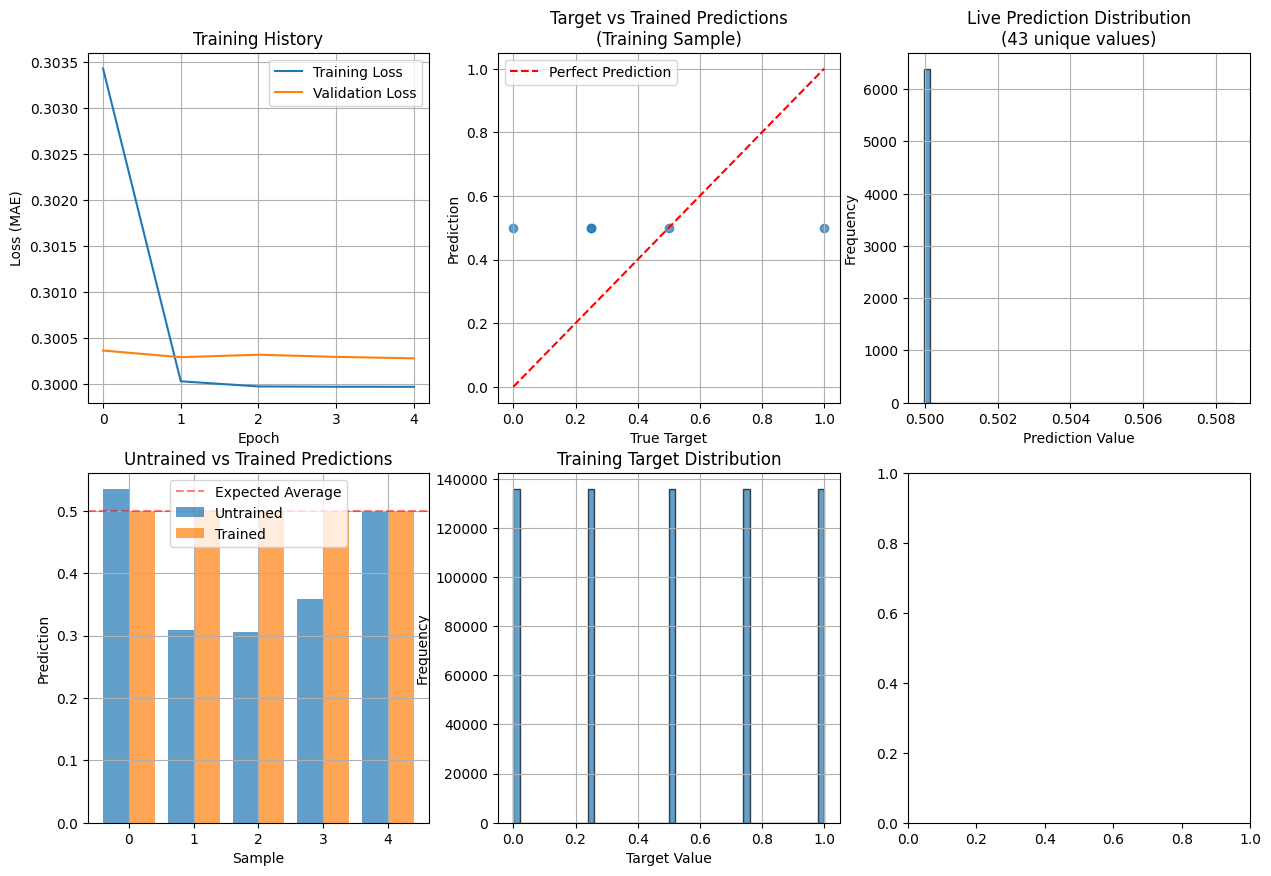

In [8]:
# Visualize prediction distribution
print("=== VISUALIZATION ===")

plt.figure(figsize=(15, 10))

# Plot 1: Training history
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)

# Plot 2: Target vs Predictions on training sample
plt.subplot(2, 3, 2)
plt.scatter(sample_y, trained_preds, alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
plt.title('Target vs Trained Predictions\n(Training Sample)')
plt.xlabel('True Target')
plt.ylabel('Prediction')
plt.legend()
plt.grid(True)

# Plot 3: Live prediction distribution
plt.subplot(2, 3, 3)
plt.hist(live_preds, bins=50, alpha=0.7, edgecolor='black')
plt.title(f'Live Prediction Distribution\n({len(set(np.round(live_preds, 6)))} unique values)')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.grid(True)

# Plot 4: Comparison of untrained vs trained
plt.subplot(2, 3, 4)
x_pos = np.arange(5)
plt.bar(x_pos - 0.2, untrained_preds, 0.4, label='Untrained', alpha=0.7)
plt.bar(x_pos + 0.2, trained_preds, 0.4, label='Trained', alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Expected Average')
plt.title('Untrained vs Trained Predictions')
plt.xlabel('Sample')
plt.ylabel('Prediction')
plt.legend()
plt.grid(True)

# Plot 5: Target distribution
plt.subplot(2, 3, 5)
plt.hist(train_targets, bins=50, alpha=0.7, edgecolor='black')
plt.title('Training Target Distribution')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.grid(True)

# Plot 6: Model weights visualization (first layer)
plt.subplot(2, 3, 6)
weights = model.layers[1].get_weights()[0]  # First dense layer weights
plt.imshow(weights[:10, :10], cmap='viridis', aspect='auto')
plt.title('Model Weights (First 10x10)')
plt.xlabel('Output Neurons')
plt.ylabel('Input Features')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# Final diagnosis
print("=== FINAL DIAGNOSIS ===")

# Check model architecture one more time
print("\n1. MODEL ARCHITECTURE:")
print(f"   - Input shape: {model.input_shape}")
print(f"   - Output shape: {model.output_shape}")
print(f"   - Last layer activation: {model.layers[-1].activation.__name__}")
print(f"   - Total parameters: {model.count_params():,}")

# Check training effectiveness
print("\n2. TRAINING EFFECTIVENESS:")
loss_improvement = history.history['loss'][0] - history.history['loss'][-1]
print(f"   - Loss improvement: {loss_improvement:.6f}")
print(f"   - Model learned: {'YES' if loss_improvement > 0.001 else 'NO'}")

# Check prediction variety
print("\n3. PREDICTION ANALYSIS:")
unique_predictions = len(set(np.round(live_preds, 6)))
total_predictions = len(live_preds)
print(f"   - Total predictions: {total_predictions:,}")
print(f"   - Unique predictions: {unique_predictions:,}")
print(f"   - Variety ratio: {unique_predictions/total_predictions:.6f}")
print(f"   - Prediction std: {live_preds.std():.6f}")

# Final verdict
print("\n4. VERDICT:")
if live_preds.std() < 1e-6:
    print("   ❌ FAILED: Model outputs same value for all inputs")
    print("   Possible causes:")
    print("   - Model architecture issue (wrong activation)")
    print("   - Training data preprocessing issue")
    print("   - ModelRunner predict method bug")
    print("   - Model not actually training")
elif unique_predictions < 100:
    print("   ⚠️  LIMITED: Model has very low prediction variety")
    print("   - May need more training epochs")
    print("   - Consider different loss function")
else:
    print("   ✅ SUCCESS: Model produces varied continuous predictions")
    print("   - Model architecture is correct")
    print("   - Training is effective")
    print("   - Predictions show proper variation")

print(f"\nPrediction range: [{live_preds.min():.6f}, {live_preds.max():.6f}]")
print(f"Expected range for sigmoid: [0.0, 1.0]")
print(f"\nFirst 5 live predictions: {live_preds[:5]}")

=== FINAL DIAGNOSIS ===

1. MODEL ARCHITECTURE:
   - Input shape: (None, 42)
   - Output shape: (None, 1)
   - Last layer activation: sigmoid
   - Total parameters: 16,769

2. TRAINING EFFECTIVENESS:
   - Loss improvement: 0.003458
   - Model learned: YES

3. PREDICTION ANALYSIS:
   - Total predictions: 6,382
   - Unique predictions: 43
   - Variety ratio: 0.006738
   - Prediction std: 0.000132

4. VERDICT:
   ⚠️  LIMITED: Model has very low prediction variety
   - May need more training epochs
   - Consider different loss function

Prediction range: [0.499967, 0.508512]
Expected range for sigmoid: [0.0, 1.0]

First 5 live predictions: [0.5000217 0.5000217 0.5000217 0.5000217 0.5000123]


: 